In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

/home/conan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## We will try to solve the Large Movie Review Dataset v1.0 task from Mass et al. The dataset consists of IMDB movie reviews labeled by positivity from 1 to 10. The task is to label the reviews as negative or positive.

In [2]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
    data = {}
    data["sentence"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
        with tf.gfile.GFile(os.path.join(directory,file_path),"r") as f:
            data["sentence"].append(f.read())
            data["sentiment"].append(re.match("\d+_(\d+)\.txt",file_path).group(1))
    return pd.DataFrame.from_dict(data)

In [3]:
# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory,"pos"))
    neg_df = load_directory_data(os.path.join(directory,"neg"))
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

In [4]:
def download_and_load_datasets(force_download=False):
    dataset = tf.keras.utils.get_file(
        fname = "aclImdb.tar.gz",
        origin = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
        extract=True
    )
    train_df = load_dataset(os.path.join(os.path.dirname(dataset),"aclImdb","train"))
    test_df = load_dataset(os.path.join(os.path.dirname(dataset),"aclImdb","test"))
    return train_df, test_df

In [5]:
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,sentiment,polarity
0,When I was young I had seen very few movies. M...,8,1
1,Not as bad a film as i thought it would be.<br...,7,1
2,Ya know when one looks at this Brian DePalma f...,10,1
3,This is an abysmal piece of story-telling. It ...,1,0
4,"Paulie sounds like the most saccharine, lachry...",7,1


## Model
### Input functions

In [6]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(train_df,train_df["polarity"], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(train_df,train_df["polarity"],shuffle=False)

# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(test_df, test_df["polarity"], shuffle=False)

# Feature columns
nnlm-en-dim128 hashes words not present in vocabulary into ~20.000 buckets
Maps from text to 128-dimensional embedding vectors.

In [11]:
embedded_text_feature_column = hub.text_embedding_column(
    key = "sentence",
    module_spec = "./3"
)

## Estimator

In [12]:
#session_config = tf.ConfigProto(log_device_placement=True)
#session_config.gpu_options.per_process_gpu_memory_fraction = 0.7
#run_config = tf.estimator.RunConfig().replace(session_config=session_config)

estimator = tf.estimator.DNNClassifier(
    hidden_units = [500,100],
    feature_columns = [embedded_text_feature_column],
    n_classes = 2,
    optimizer = tf.train.AdagradOptimizer(learning_rate=0.003),
    #config=run_config
)

## Training

In [13]:
estimator.train(input_fn=train_input_fn, steps=1000)

## Prediction

In [14]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

Training set accuracy: 0.8441200256347656
Test set accuracy: 0.843999981880188


## Confusion matrix

In [15]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]
    
LABELS = [ "negative", "positive"]    

Text(33,0.5,'True')

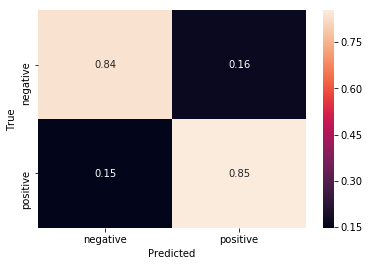

In [16]:
# Create a confusion matrix on training data.
with tf.Graph().as_default():
    cm = tf.confusion_matrix(train_df["polarity"],
                            get_predictions(estimator, predict_train_input_fn))
    with tf.Session() as session:
        cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float)/cm_out.sum(axis=1)[:,np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS)

plt.xlabel("Predicted")
plt.ylabel("True")